In [1]:
# sentiment_analysis_novel_with_custom_loss.py

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from spektral.layers import GATConv, TopKPool
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import logging

# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# -------------------------------
# 1. Data Preparation
# -------------------------------

# Load the dataset
df = pd.read_csv(r"F:\Context-Resonance Transformer\Cricket\Cricket - Sheet1.csv")  # Replace with your dataset path
df = df[['Text', 'Category', 'Polarity']]
print("Initial DataFrame:")
print(df.head())
print(f"Initial Data Shape: {df.shape}")

# Initialize Bengali stopwords
nltk.download('stopwords')

# Load Bengali stopwords
try:
    stop_words = set(stopwords.words('bengali'))
except LookupError:
    print("Bengali stopwords not found. Skipping stopword removal.")
    stop_words = set()

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    if stop_words:
        words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)
print("DataFrame after text cleaning:")
print(df.head())

# Upsample classes to balance the dataset
from sklearn.utils import resample

def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode labels
category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_sentences(sentences, tokenizer, max_len=20, batch_size=32):
    input_ids = []
    attention_masks = []
    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        encoded = tokenizer(
            list(batch),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()
    return input_ids, attention_masks

# Tokenize the data
input_ids, attention_masks = tokenize_sentences(df_upsampled['Text'].values, tokenizer, max_len=20, batch_size=32)

# Create window-based adjacency matrices
def window_based_adjacency(sentences, window_size=2, max_len=20):
    adjacency_matrices = []
    for sentence in sentences:
        tokens = sentence.split()[:max_len]
        num_tokens = len(tokens)
        adj = np.zeros((max_len, max_len), dtype=np.float32)
        for i in range(num_tokens):
            for j in range(max(i - window_size, 0), min(i + window_size + 1, num_tokens)):
                if i != j:
                    adj[i, j] = 1.0
        adjacency_matrices.append(adj)
    return np.array(adjacency_matrices, dtype=np.float32)

adjacency_matrices = window_based_adjacency(df_upsampled['Text'].values, window_size=2, max_len=20)

# Define labels
labels_category = df_upsampled['Category_encoded'].values
labels_polarity = df_upsampled['Polarity_encoded'].values

# Split the data
X_train_ids, X_test_ids, X_train_masks, X_test_masks, adjacency_train, adjacency_test, y_train_category, y_test_category, y_train_polarity, y_test_polarity = train_test_split(
    input_ids, attention_masks, adjacency_matrices, labels_category, labels_polarity, test_size=0.2, random_state=42, stratify=labels_category
)

f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initial DataFrame:
                                                Text Category  Polarity
0  জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...    other  positive
1  জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...     team  positive
2               বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?     team  positive
3                              সৌম্যকে বাদ দেওয়া হোক  batting  negative
4  প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...     team  positive
Initial Data Shape: (2979, 3)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


DataFrame after text cleaning:
                                                Text Category  Polarity
0  জয় বাংলা কাপ স্বাধীনতার মাস মার্চে মাথা চমৎকার...    other  positive
1  জয় বাংলা কাপ স্বাধীনতার মাস মার্চে মাথা চমৎকার...     team  positive
2                           বাংলাদেশের ভারতের সাপর্ট     team  positive
3                                        সৌম্যকে বাদ  batting  negative
4            প্রথমটি কোচ অতপর সাকিবসাকিব সাকিবরে দলে     team  positive


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 329/329 [00:03<00:00, 103.93it/s]


In [2]:
# -------------------------------
# 2. Model Architecture
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Concatenate, Embedding, Flatten, Layer
from tensorflow.keras.models import Model
from spektral.layers import GATConv

def squash(vectors):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=-1, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm)
    unit_vectors = vectors / tf.sqrt(s_squared_norm + 1e-9)
    return scale * unit_vectors

# Custom Multi-Head Attention Layer
class CustomMultiHeadAttention(Layer):
    def __init__(self, num_heads, key_dim, max_len, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.depth = key_dim // num_heads
        self.max_len = max_len

    def build(self, input_shape):
        if isinstance(input_shape, list) and len(input_shape) == 3:
            q_shape, k_shape, v_shape = input_shape
        else:
            q_shape = input_shape
            k_shape = input_shape
            v_shape = input_shape
        self.wq = self.add_weight(shape=(q_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wk = self.add_weight(shape=(k_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wv = self.add_weight(shape=(v_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        super(CustomMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, self.max_len, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)

    def call(self, inputs, mask=None):
        if isinstance(inputs, list) and len(inputs) == 3:
            q, k, v = inputs
        else:
            q = inputs
            k = inputs
            v = inputs
        batch_size = tf.shape(q)[0]

        q = tf.matmul(q, self.wq)
        k = tf.matmul(k, self.wk)
        v = tf.matmul(v, self.wv)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, self.max_len, self.key_dim))

        # Set shapes for Keras
        concat_attention.set_shape((None, self.max_len, self.key_dim))
        attention_weights.set_shape((None, self.num_heads, self.max_len, self.max_len))

        return concat_attention, attention_weights

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            batch_size = input_shape[0][0]
        else:
            batch_size = input_shape[0]
        return (batch_size, self.max_len, self.key_dim)



# Updated GNNContextResonance Layer without TopKPool
class GNNContextResonance(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_heads=8, max_len=20, dropout_rate=0.2, **kwargs):
        super(GNNContextResonance, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.max_len = max_len
        self.dropout_rate = dropout_rate

        # Positional Encoding
        self.position_embedding = Embedding(input_dim=max_len, output_dim=hidden_size)

        # Multi-Head GAT Layers with Edge Attention and Residual Connections
        self.gat_layers = [GATConv(hidden_size // num_heads, activation='elu') for _ in range(num_heads)]
        self.concat = Concatenate()

        # Highway Network for Modulation
        self.transform_gate = Dense(hidden_size, activation='sigmoid')
        self.carry_gate = Dense(hidden_size, activation='sigmoid')

        # Dropout and Layer Norm
        self.dropout = Dropout(dropout_rate)
        self.layer_norm = LayerNormalization(epsilon=1e-6)

        # Dense layer for resonance scores
        self.dense = Dense(1, activation='sigmoid')

    def call(self, inputs, adjacency, edge_features=None, training=False):
        """
        inputs: BERT embeddings (batch_size, seq_length, hidden_size)
        adjacency: Adjacency matrices (batch_size, seq_length, seq_length)
        edge_features: Edge features (batch_size, seq_length, seq_length, edge_feature_dim)
        """
        # Positional Encoding
        position_indices = tf.range(self.max_len)[tf.newaxis, :]
        position_embeddings = self.position_embedding(position_indices)
        inputs = inputs + position_embeddings

        # Multi-Head GAT
        gat_outputs = []
        for gat_layer in self.gat_layers:
            x = gat_layer([inputs, adjacency])
            gat_outputs.append(x)
        x = self.concat(gat_outputs) 

        # Residual Connection
        x = x + inputs 

        # Highway Network for Modulation
        transform = self.transform_gate(x)
        carry = self.carry_gate(inputs)
        outputs = transform * x + (1 - transform) * carry

        # Apply dropout and layer normalization
        outputs = self.dropout(outputs, training=training)
        outputs = self.layer_norm(outputs)

        # Compute resonance scores
        resonance_scores = self.dense(outputs)

        return outputs, resonance_scores
    

    
def build_model_with_gnn(bert_model, hidden_size, max_len=20):
    # Define Inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')
    adjacency = Input(shape=(max_len, max_len), dtype=tf.float32, name='adjacency')

    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  

    # Apply GNN-Based ContextResonance
    gnn_resonance_layer = GNNContextResonance(hidden_size, num_heads=8, max_len=max_len)
    gnn_output, resonance_scores = gnn_resonance_layer(sequence_output, adjacency)

    # Implement Dual Attention Mechanism
    # Self-attention over GNN outputs
    self_attention_layer = CustomMultiHeadAttention(num_heads=8, key_dim=hidden_size, max_len=max_len)
    self_attention_output, self_attention_scores = self_attention_layer([gnn_output, gnn_output, gnn_output])

    # Cross-attention between BERT outputs and GNN outputs
    cross_attention_layer = CustomMultiHeadAttention(num_heads=8, key_dim=hidden_size, max_len=max_len)
    cross_attention_output, cross_attention_scores = cross_attention_layer([sequence_output, gnn_output, gnn_output])

    # Combine outputs
    combined_output = Concatenate(axis=-1)([self_attention_output, cross_attention_output])

    # Apply Capsule Networks After GNN
    caps_num_capsules = 10  # Number of capsules
    caps_dim_capsules = 16  # Dimension of each capsule

    # Primary Capsule Layer
    primary_capsules = tf.keras.layers.Conv1D(
        filters=caps_num_capsules * caps_dim_capsules,
        kernel_size=1,
        strides=1,
        padding='valid'
    )(combined_output)

    primary_capsules = tf.keras.layers.Reshape(
        target_shape=(max_len, caps_num_capsules, caps_dim_capsules)
    )(primary_capsules)

    primary_capsules = tf.keras.layers.Lambda(squash, name='primary_caps_squash')(primary_capsules)

    # Flatten capsules
    flat_capsules = Flatten()(primary_capsules)

    # Classification Heads for Hierarchical Multi-Task Learning
    dropout = Dropout(0.3)(flat_capsules)

    # Category Output
    category_output = Dense(len(category_encoder.classes_), activation='softmax', name='category_output')(dropout)

    # Combine flat capsules and category prediction for polarity prediction
    combined_input = Concatenate()([dropout, category_output])

    # Polarity Output uses combined input
    polarity_dropout = Dropout(0.3)(combined_input)
    polarity_output = Dense(len(polarity_encoder.classes_), activation='softmax', name='polarity_output')(polarity_dropout)

    # Include `flat_capsules` and attention scores in the outputs
    model = Model(
        inputs=[input_ids, attention_masks, adjacency],
        outputs=[category_output, polarity_output, resonance_scores, flat_capsules, self_attention_scores, cross_attention_scores]
    )

    return model

# Load pre-trained multilingual BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
hidden_size = bert_model.config.hidden_size  # Typically 768

# Build the model
model = build_model_with_gnn(bert_model, hidden_size, max_len=20)

# Summary of the model
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 20,                                            

In [3]:

# -------------------------------
# 3. Defining Custom Loss Functions and Metrics
# -------------------------------

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss functions with 'none' reduction to get per-sample losses
loss_fn_category = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
loss_fn_polarity = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

# Define metrics
train_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_category')
train_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_polarity')
val_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_category')
val_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_polarity')

# Compute class weights based on the training labels for both tasks
class_weights_category = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_category),
    y=y_train_category
)

class_weights_polarity = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_polarity),
    y=y_train_polarity
)

# Convert class_weights to dictionaries for easy lookup
class_weights_dict_category = {i: weight for i, weight in enumerate(class_weights_category)}
class_weights_dict_polarity = {i: weight for i, weight in enumerate(class_weights_polarity)}
print("Category Class Weights:", class_weights_dict_category)
print("Polarity Class Weights:", class_weights_dict_polarity)

# Define the supervised contrastive loss function
def supervised_contrastive_loss(labels, features, temperature=0.1):
    labels = tf.reshape(labels, [-1])
    label_mask = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    features = tf.math.l2_normalize(features, axis=1)
    similarity_matrix = tf.matmul(features, features, transpose_b=True) / temperature
    logits_max = tf.reduce_max(similarity_matrix, axis=1, keepdims=True)
    logits = similarity_matrix - logits_max
    exp_logits = tf.exp(logits) * tf.cast(label_mask, tf.float32)
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-8)
    mean_log_prob_pos = tf.reduce_sum(log_prob * tf.cast(label_mask, tf.float32), axis=1) / tf.reduce_sum(tf.cast(label_mask, tf.float32), axis=1)
    loss = -tf.reduce_mean(mean_log_prob_pos)
    return loss

# -------------------------------
# 4. Custom Training Loop
# -------------------------------

@tf.function
def train_step(input_ids, attention_masks, adjacency, labels_category, labels_polarity):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model([input_ids, attention_masks, adjacency], training=True)
        predictions_category = predictions[0]
        predictions_polarity = predictions[1]
        resonance_scores = predictions[2]
        features = predictions[3]

        # Compute per-sample standard loss for category
        cce_loss_category = loss_fn_category(labels_category, predictions_category)

        # Compute per-sample standard loss for polarity
        cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

        # Apply class weights
        class_weights_tensor_category = tf.gather(tf.constant(class_weights_category, dtype=tf.float32), labels_category)
        class_weights_tensor_polarity = tf.gather(tf.constant(class_weights_polarity, dtype=tf.float32), labels_polarity)

        weighted_cce_loss_category = cce_loss_category * class_weights_tensor_category
        weighted_cce_loss_category_mean = tf.reduce_mean(weighted_cce_loss_category)

        weighted_cce_loss_polarity = cce_loss_polarity * class_weights_tensor_polarity
        weighted_cce_loss_polarity_mean = tf.reduce_mean(weighted_cce_loss_polarity)

        # Compute smoothness loss
        resonance_scores_squeezed = tf.squeeze(resonance_scores, axis=-1)  # (batch_size, seq_length)
        resonance_diff = resonance_scores_squeezed[:, :, tf.newaxis] - resonance_scores_squeezed[:, tf.newaxis, :]
        squared_diff = tf.square(resonance_diff)
        smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1,2])  # (batch_size,)
        smoothness_loss = tf.reduce_mean(smoothness_loss)

        # Compute contrastive loss on the features
        contrastive_loss_value = supervised_contrastive_loss(labels_category, features)

        # Total loss
        alpha = 1e-5  # Weight for smoothness loss
        beta = 1e-5 # Weight for contrastive loss
        total_loss = (weighted_cce_loss_category_mean + weighted_cce_loss_polarity_mean
                      + alpha * smoothness_loss + beta * contrastive_loss_value)

    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)

    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update metrics
    train_accuracy_category.update_state(labels_category, predictions_category)
    train_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, weighted_cce_loss_category_mean, weighted_cce_loss_polarity_mean, smoothness_loss, contrastive_loss_value

@tf.function
def test_step(input_ids, attention_masks, adjacency, labels_category, labels_polarity):
    # Forward pass
    predictions = model([input_ids, attention_masks, adjacency], training=False)
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]
    resonance_scores = predictions[2]
    features = predictions[3]

    # Compute per-sample standard loss for category
    cce_loss_category = loss_fn_category(labels_category, predictions_category)

    # Compute per-sample standard loss for polarity
    cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

    # Apply class weights
    class_weights_tensor_category = tf.gather(tf.constant(class_weights_category, dtype=tf.float32), labels_category)
    class_weights_tensor_polarity = tf.gather(tf.constant(class_weights_polarity, dtype=tf.float32), labels_polarity)

    weighted_cce_loss_category = cce_loss_category * class_weights_tensor_category
    weighted_cce_loss_category_mean = tf.reduce_mean(weighted_cce_loss_category)

    weighted_cce_loss_polarity = cce_loss_polarity * class_weights_tensor_polarity
    weighted_cce_loss_polarity_mean = tf.reduce_mean(weighted_cce_loss_polarity)

    # Compute smoothness loss
    resonance_scores_squeezed = tf.squeeze(resonance_scores, axis=-1)
    resonance_diff = resonance_scores_squeezed[:, :, tf.newaxis] - resonance_scores_squeezed[:, tf.newaxis, :]
    squared_diff = tf.square(resonance_diff)
    smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1,2])
    smoothness_loss = tf.reduce_mean(smoothness_loss)

    # Compute contrastive loss on the features
    contrastive_loss_value = supervised_contrastive_loss(labels_category, features)

    # Total loss
    alpha = 1e-5
    beta = 1e-5
    total_loss = (weighted_cce_loss_category_mean + weighted_cce_loss_polarity_mean
                  + alpha * smoothness_loss + beta * contrastive_loss_value)

    # Update metrics
    val_accuracy_category.update_state(labels_category, predictions_category)
    val_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, weighted_cce_loss_category_mean, weighted_cce_loss_polarity_mean, smoothness_loss, contrastive_loss_value

# -------------------------------
# 5. Training the Model
# -------------------------------

epochs = 20
batch_size = 16
alpha = 1e-5
beta = 1e-5

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_ids,
        'attention_masks': X_train_masks,
        'adjacency': adjacency_train
    },
    y_train_category,
    y_train_polarity
)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_ids,
        'attention_masks': X_test_masks,
        'adjacency': adjacency_test
    },
    y_test_category,
    y_test_polarity
)).batch(batch_size)



# Import the time module
import time

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss_category': [],
    'train_cce_loss_polarity': [],
    'train_smoothness_loss': [],
    'train_contrastive_loss': [],
    'train_accuracy_category': [],
    'train_accuracy_polarity': [],
    'val_loss': [],
    'val_cce_loss_category': [],
    'val_cce_loss_polarity': [],
    'val_smoothness_loss': [],
    'val_contrastive_loss': [],
    'val_accuracy_category': [],
    'val_accuracy_polarity': [],
    'epoch_time': []  # Added to record time per epoch
}

# Start time of training
training_start_time = time.time()

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")
    epoch_start_time = time.time()  # Record start time of the epoch

    # Reset metrics at the start of each epoch
    train_accuracy_category.reset_states()
    train_accuracy_polarity.reset_states()
    val_accuracy_category.reset_states()
    val_accuracy_polarity.reset_states()

    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_category_avg = tf.keras.metrics.Mean()
    cce_loss_polarity_avg = tf.keras.metrics.Mean()
    smoothness_loss_avg = tf.keras.metrics.Mean()
    contrastive_loss_avg = tf.keras.metrics.Mean()

    for step, (batch_inputs, batch_labels_category, batch_labels_polarity) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol, smoothness_loss, contrastive_loss_value = train_step(
            input_ids, attention_masks, adjacency, labels_category, labels_polarity)

        total_loss_avg.update_state(total_loss)
        cce_loss_category_avg.update_state(cce_loss_cat)
        cce_loss_polarity_avg.update_state(cce_loss_pol)
        smoothness_loss_avg.update_state(smoothness_loss)
        contrastive_loss_avg.update_state(contrastive_loss_value)

        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, "
                  f"CCE Loss Category = {cce_loss_category_avg.result():.4f}, "
                  f"CCE Loss Polarity = {cce_loss_polarity_avg.result():.4f}, "
                  f"Smoothness Loss = {smoothness_loss_avg.result():.4f}, "
                  f"Contrastive Loss = {contrastive_loss_avg.result():.4f}, "
                  f"Train Accuracy Category = {train_accuracy_category.result():.4f}, "
                  f"Train Accuracy Polarity = {train_accuracy_polarity.result():.4f}")

    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss_category'].append(cce_loss_category_avg.result().numpy())
    history['train_cce_loss_polarity'].append(cce_loss_polarity_avg.result().numpy())
    history['train_smoothness_loss'].append(smoothness_loss_avg.result().numpy())
    history['train_contrastive_loss'].append(contrastive_loss_avg.result().numpy())
    history['train_accuracy_category'].append(train_accuracy_category.result().numpy())
    history['train_accuracy_polarity'].append(train_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Category: {cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Polarity: {cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Smoothness Loss: {smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Contrastive Loss: {contrastive_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Category: {train_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Polarity: {train_accuracy_polarity.result():.4f}")

    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_category_avg = tf.keras.metrics.Mean()
    val_cce_loss_polarity_avg = tf.keras.metrics.Mean()
    val_smoothness_loss_avg = tf.keras.metrics.Mean()
    val_contrastive_loss_avg = tf.keras.metrics.Mean()

    for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol, smoothness_loss, contrastive_loss_value = test_step(
            input_ids, attention_masks, adjacency, labels_category, labels_polarity)

        val_loss_avg.update_state(total_loss)
        val_cce_loss_category_avg.update_state(cce_loss_cat)
        val_cce_loss_polarity_avg.update_state(cce_loss_pol)
        val_smoothness_loss_avg.update_state(smoothness_loss)
        val_contrastive_loss_avg.update_state(contrastive_loss_value)

    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss_category'].append(val_cce_loss_category_avg.result().numpy())
    history['val_cce_loss_polarity'].append(val_cce_loss_polarity_avg.result().numpy())
    history['val_smoothness_loss'].append(val_smoothness_loss_avg.result().numpy())
    history['val_contrastive_loss'].append(val_contrastive_loss_avg.result().numpy())
    history['val_accuracy_category'].append(val_accuracy_category.result().numpy())
    history['val_accuracy_polarity'].append(val_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Category: {val_cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Polarity: {val_cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Smoothness Loss: {val_smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Contrastive Loss: {val_contrastive_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Category: {val_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Polarity: {val_accuracy_polarity.result():.4f}")

    # Calculate epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    history['epoch_time'].append(epoch_duration)
    print(f"Epoch {epoch+1} Duration: {epoch_duration:.2f} seconds")

# Total training time
training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")


Category Class Weights: {0: 0.9432902863559798, 1: 0.7503349709691827, 2: 1.0980392156862746, 3: 1.0029850746268656, 4: 1.4297872340425533}
Polarity Class Weights: {0: 1.0104655359076147, 1: 0.9950248756218906, 2: 0.9946714031971581}

Start of epoch 1
Step 0: Total Loss = 2.7617, CCE Loss Category = 1.7713, CCE Loss Polarity = 0.9904, Smoothness Loss = 1.9986, Contrastive Loss = 3.2170, Train Accuracy Category = 0.2500, Train Accuracy Polarity = 0.6875
Step 100: Total Loss = 2.5440, CCE Loss Category = 1.4667, CCE Loss Polarity = 1.0772, Smoothness Loss = 1.5678, Contrastive Loss = 2.4913, Train Accuracy Category = 0.3899, Train Accuracy Polarity = 0.4226
Step 200: Total Loss = 2.2820, CCE Loss Category = 1.2818, CCE Loss Polarity = 1.0002, Smoothness Loss = 1.4542, Contrastive Loss = 3.2651, Train Accuracy Category = 0.4925, Train Accuracy Polarity = 0.4984
Step 300: Total Loss = 2.0300, CCE Loss Category = 1.1247, CCE Loss Polarity = 0.9052, Smoothness Loss = 1.3501, Contrastive Loss

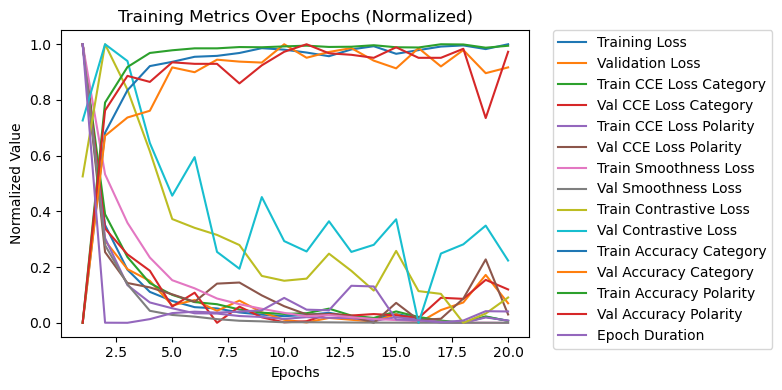

Total Training Time: 1381.05 seconds


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Collect all metrics to plot
    metrics_to_plot = [
        ('train_loss', 'Training Loss'),
        ('val_loss', 'Validation Loss'),
        ('train_cce_loss_category', 'Train CCE Loss Category'),
        ('val_cce_loss_category', 'Val CCE Loss Category'),
        ('train_cce_loss_polarity', 'Train CCE Loss Polarity'),
        ('val_cce_loss_polarity', 'Val CCE Loss Polarity'),
        ('train_smoothness_loss', 'Train Smoothness Loss'),
        ('val_smoothness_loss', 'Val Smoothness Loss'),
        ('train_contrastive_loss', 'Train Contrastive Loss'),
        ('val_contrastive_loss', 'Val Contrastive Loss'),
        ('train_accuracy_category', 'Train Accuracy Category'),
        ('val_accuracy_category', 'Val Accuracy Category'),
        ('train_accuracy_polarity', 'Train Accuracy Polarity'),
        ('val_accuracy_polarity', 'Val Accuracy Polarity'),
        ('epoch_time', 'Epoch Duration')
    ]

    # Normalize all metrics to 0-1 range for plotting
    normalized_metrics = {}
    for key, label in metrics_to_plot:
        data = history[key]
        min_val = min(data)
        max_val = max(data)
        if max_val - min_val == 0:
            # Avoid division by zero
            normalized_data = [0.0 for _ in data]
        else:
            normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
        normalized_metrics[label] = normalized_data

    # Plot all metrics on the same plot
    plt.figure(figsize=(8, 4))

    for label, data in normalized_metrics.items():
        plt.plot(epochs, data, label=label)

    plt.title('Training Metrics Over Epochs (Normalized)')
    plt.xlabel('Epochs')
    plt.ylabel('Normalized Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


# After training is complete
plot_training_history(history)

# Display total training time
print(f"Total Training Time: {total_training_time:.2f} seconds")

1/1 [==============================] - 0s 96ms/step
Test Accuracy (Category): 0.9181
Test Macro F1 Score (Category): 0.9178
Test Macro Precision (Category): 0.9169
Test Macro Recall (Category): 0.9199
Test Accuracy (Polarity): 0.9776
Test Macro F1 Score (Polarity): 0.9776
Test Macro Precision (Polarity): 0.9776
Test Macro Recall (Polarity): 0.9780


<Figure size 400x400 with 0 Axes>

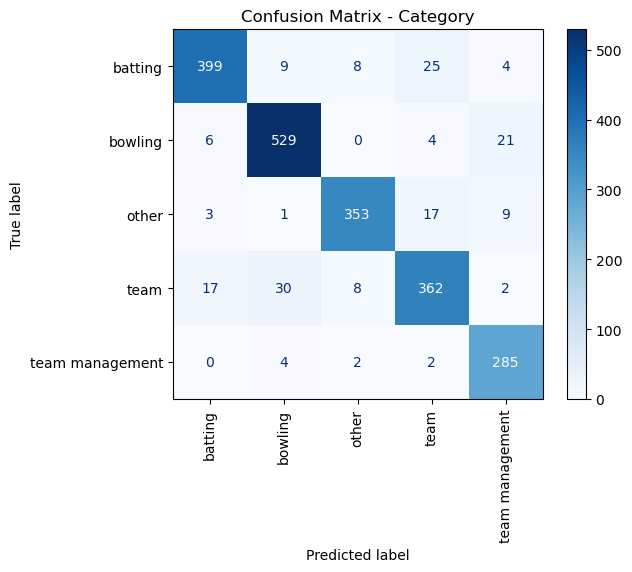

<Figure size 400x400 with 0 Axes>

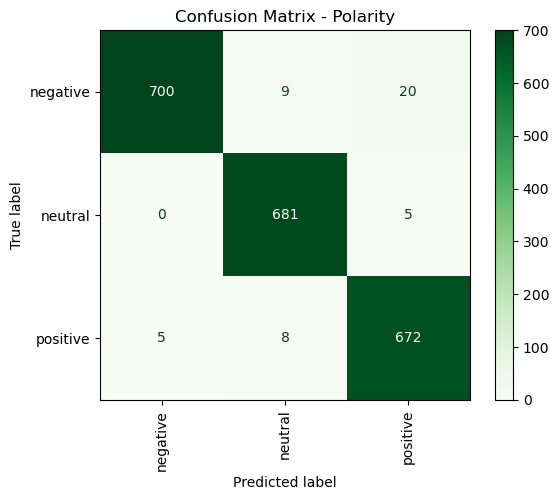

In [5]:
# -------------------------------
# 6. Evaluation and Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
all_predictions_category = []
all_predictions_polarity = []
all_labels_category = []
all_labels_polarity = []
all_resonance_scores = []

for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']
    adjacency = batch_inputs['adjacency']

    predictions = model.predict([input_ids, attention_masks, adjacency])
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]
    resonance_scores = predictions[2]
    # features = predictions[3]  # Features from the capsule network

    predicted_labels_category = np.argmax(predictions_category, axis=1)
    predicted_labels_polarity = np.argmax(predictions_polarity, axis=1)

    all_predictions_category.extend(predicted_labels_category)
    all_predictions_polarity.extend(predicted_labels_polarity)
    all_labels_category.extend(batch_labels_category.numpy())
    all_labels_polarity.extend(batch_labels_polarity.numpy())
    all_resonance_scores.extend(resonance_scores)

# Convert lists to numpy arrays
all_labels_category = np.array(all_labels_category)
all_predictions_category = np.array(all_predictions_category)
all_labels_polarity = np.array(all_labels_polarity)
all_predictions_polarity = np.array(all_predictions_polarity)

# Calculate metrics for Category
accuracy_category = accuracy_score(all_labels_category, all_predictions_category)
f1_category = f1_score(all_labels_category, all_predictions_category, average='macro')
precision_category = precision_score(all_labels_category, all_predictions_category, average='macro')
recall_category = recall_score(all_labels_category, all_predictions_category, average='macro')

print(f"Test Accuracy (Category): {accuracy_category:.4f}")
print(f"Test Macro F1 Score (Category): {f1_category:.4f}")
print(f"Test Macro Precision (Category): {precision_category:.4f}")
print(f"Test Macro Recall (Category): {recall_category:.4f}")

# Calculate metrics for Polarity
accuracy_polarity = accuracy_score(all_labels_polarity, all_predictions_polarity)
f1_polarity = f1_score(all_labels_polarity, all_predictions_polarity, average='macro')
precision_polarity = precision_score(all_labels_polarity, all_predictions_polarity, average='macro')
recall_polarity = recall_score(all_labels_polarity, all_predictions_polarity, average='macro')

print(f"Test Accuracy (Polarity): {accuracy_polarity:.4f}")
print(f"Test Macro F1 Score (Polarity): {f1_polarity:.4f}")
print(f"Test Macro Precision (Polarity): {precision_polarity:.4f}")
print(f"Test Macro Recall (Polarity): {recall_polarity:.4f}")


plt.figure(figsize=(4, 4))
# Confusion Matrix for Category
cm_category = confusion_matrix(all_labels_category, all_predictions_category)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_category, display_labels=category_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title('Confusion Matrix - Category')
plt.show()

plt.figure(figsize=(4, 4))
# Confusion Matrix for Polarity
cm_polarity = confusion_matrix(all_labels_polarity, all_predictions_polarity)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_polarity, display_labels=polarity_encoder.classes_)
disp.plot(cmap='Greens', xticks_rotation=90)
plt.title('Confusion Matrix - Polarity')
plt.show()




In [6]:
# -------------------------------
# 6. Evaluation and Visualization
# -------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib
import numpy as np

# Specify the font path
font_path = r"F:\Context-Resonance Transformer\TiroBangla-Regular.ttf"

# Add the font properties
font_prop = fm.FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

# Function to decode tokens
def decode_tokens(input_ids, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    return tokens

# Function to visualize resonance scores and attention maps
def visualize_resonance_and_attention(tokens, resonance_scores, self_attention_scores, cross_attention_scores,
                                      predicted_label_category, predicted_label_polarity,
                                      label_encoder_category, label_encoder_polarity, attention_mask=None):
    """
    Plots resonance scores and attention scores for each token in the sentence, excluding padding and special tokens.
    """
    # Convert tensors to numpy arrays if necessary
    if tf.is_tensor(tokens):
        tokens = tokens.numpy()
    if tf.is_tensor(resonance_scores):
        resonance_scores = resonance_scores.numpy()
    if tf.is_tensor(self_attention_scores):
        self_attention_scores = self_attention_scores.numpy()
    if tf.is_tensor(cross_attention_scores):
        cross_attention_scores = cross_attention_scores.numpy()

    # If attention_mask is provided, use it to filter tokens
    if attention_mask is not None:
        valid_indices = attention_mask > 0
        tokens = np.array(tokens)[valid_indices]
        resonance_scores = resonance_scores[valid_indices]
        self_attention_scores = self_attention_scores[:, :, valid_indices, :][:, :, :, valid_indices]
        cross_attention_scores = cross_attention_scores[:, :, valid_indices, :][:, :, :, valid_indices]

    # Exclude special tokens [CLS], [SEP], and [PAD] if present
    special_tokens = {'[CLS]', '[SEP]', '[PAD]'}
    mask = ~np.isin(tokens, list(special_tokens))
    tokens = np.array(tokens)[mask]
    resonance_scores = resonance_scores[mask]
    self_attention_scores = self_attention_scores[:, :, mask, :][:, :, :, mask]
    cross_attention_scores = cross_attention_scores[:, :, mask, :][:, :, :, mask]

    # Plot Resonance Scores
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(tokens)), resonance_scores, color='skyblue')
    plt.xticks(range(len(tokens)), tokens, rotation=90, fontproperties=font_prop)
    plt.title(f"Resonance Scores\nPredicted Category: {label_encoder_category.inverse_transform([predicted_label_category])[0]}, "
              f"Predicted Polarity: {label_encoder_polarity.inverse_transform([predicted_label_polarity])[0]}",
              fontproperties=font_prop)
    plt.xlabel("Tokens", fontproperties=font_prop)
    plt.ylabel("Resonance Score", fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

    # Average attention scores over heads
    avg_self_attention = np.mean(self_attention_scores[0], axis=0)  # Shape: (seq_len, seq_len)
    avg_cross_attention = np.mean(cross_attention_scores[0], axis=0)  # Shape: (seq_len, seq_len)

    # Plot Self-Attention Scores
    plt.figure(figsize=(6, 4))
    sns.heatmap(avg_self_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.xticks(rotation=90, fontproperties=font_prop)
    plt.yticks(rotation=0, fontproperties=font_prop)
    plt.title("Self-Attention Scores", fontproperties=font_prop)
    plt.xlabel("Key Tokens", fontproperties=font_prop)
    plt.ylabel("Query Tokens", fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

    # Plot Cross-Attention Scores
    plt.figure(figsize=(6, 4))
    sns.heatmap(avg_cross_attention, xticklabels=tokens, yticklabels=tokens, cmap='plasma')
    plt.xticks(rotation=90, fontproperties=font_prop)
    plt.yticks(rotation=0, fontproperties=font_prop)
    plt.title("Cross-Attention Scores", fontproperties=font_prop)
    plt.xlabel("Key Tokens (GNN Output)", fontproperties=font_prop)
    plt.ylabel("Query Tokens (BERT Output)", fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

# Visualizing Resonance Scores and Attention Maps for a Sample Sentence
def visualize_sample_resonance_and_attention(input_ids, attention_mask, adjacency, label_encoder_category, label_encoder_polarity, sample_index=0):
    """
    Visualizes resonance scores and attention maps for a single sample.
    """
    sample_input_ids = input_ids[sample_index:sample_index+1]
    sample_attention_masks = attention_mask[sample_index:sample_index+1]
    sample_adjacency = adjacency[sample_index:sample_index+1]
    sample_label_category = y_test_category[sample_index]
    sample_label_polarity = y_test_polarity[sample_index]

    # Predict sentiment and get resonance scores and attention scores
    predictions = model.predict([sample_input_ids, sample_attention_masks, sample_adjacency])
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]
    resonance_scores = predictions[2]
    features = predictions[3]
    self_attention_scores = predictions[4]
    cross_attention_scores = predictions[5]

    predicted_label_category = np.argmax(predictions_category, axis=1)[0]
    predicted_label_polarity = np.argmax(predictions_polarity, axis=1)[0]

    # Decode tokens
    tokens = decode_tokens(sample_input_ids[0], tokenizer)

    # Extract and normalize resonance scores
    resonance = resonance_scores[0].squeeze()
    # Adjust the length to match the tokens
    resonance = resonance[:len(tokens)]

    # Ensure resonance is float32 to match plotting
    resonance_normalized = (resonance - np.min(resonance)) / (np.max(resonance) - np.min(resonance) + 1e-8)
    resonance_normalized = resonance_normalized.astype(np.float32)

    # Extract attention mask for the sample
    attention_mask_sample = sample_attention_masks[0]

    # Visualize resonance scores and attention maps
    visualize_resonance_and_attention(
        tokens=tokens,
        resonance_scores=resonance_normalized,
        self_attention_scores=self_attention_scores,
        cross_attention_scores=cross_attention_scores,
        predicted_label_category=predicted_label_category,
        predicted_label_polarity=predicted_label_polarity,
        label_encoder_category=label_encoder_category,
        label_encoder_polarity=label_encoder_polarity,
        attention_mask=attention_mask_sample  # Pass attention mask to exclude padding and special tokens
    )


1/1 [==============================] - 0s 346ms/step


findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not

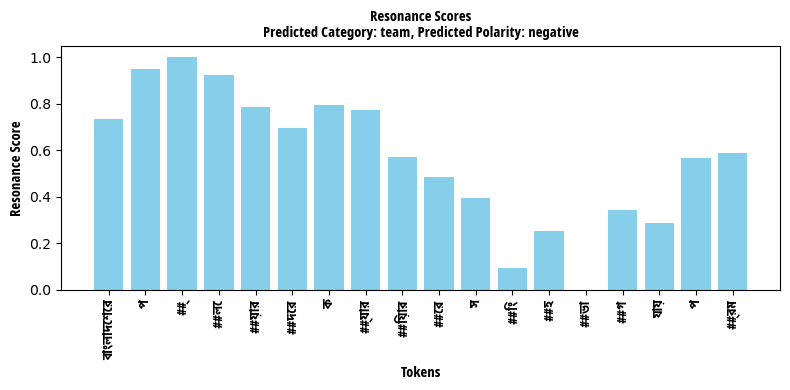

findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
f:\Mini Conda\envs\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2476 (\N{BENGALI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
f:\Mini Conda\envs\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
f:\Mini Conda\envs\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
f:\Mini Conda\envs\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2434 (\N{BENGALI SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
f:\Mini Conda\envs\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2482 (\N{BENGALI LETTER LA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
f:\Mini Conda\envs\env\lib\site-packages\seaborn\utils.py:6

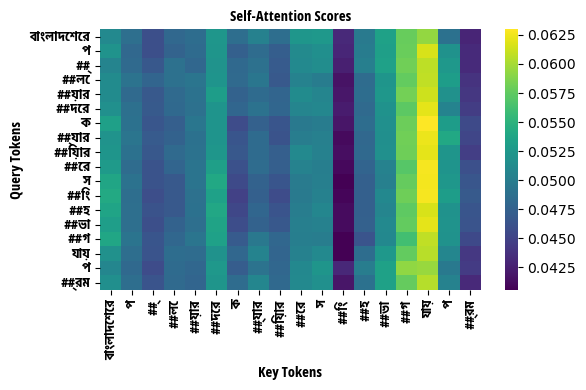

findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
f:\Mini Conda\envs\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2476 (\N{BENGALI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
f:\Mini Conda\envs\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
f:\Mini Conda\envs\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
f:\Mini Conda\envs\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2434 (\N{BENGALI SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
f:\Mini Conda\envs\env\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2482 (\N{BENGALI LETTER LA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
f:\Mini Conda\envs\env\lib\site-packages\seaborn\utils.py:6

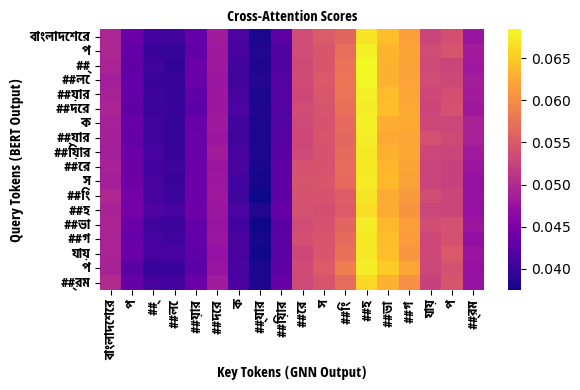

In [7]:
visualize_sample_resonance_and_attention(X_test_ids, X_test_masks, adjacency_test, category_encoder, polarity_encoder, sample_index=0)


1/1 [==============================] - 0s 94ms/step
Shape of all_features: (2100, 3200)
Shape of all_labels_category: (2100,)
Number of NaN in all_features: 0
Number of infinite values in all_features: 0
Unique labels: [0 1 2 3 4]


findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not

Length of features_2d: 2100
Length of all_labels_category: 2100


findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not found.
findfont: Font family 'Noto Sans Bengali Condensed' not

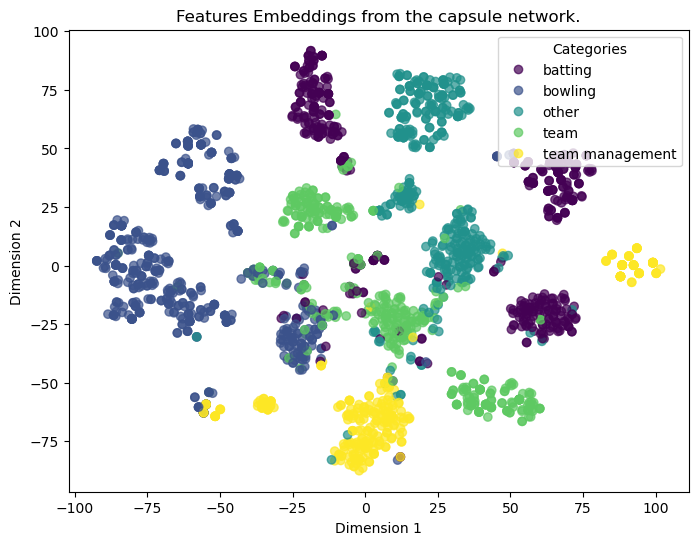

In [8]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Stack all features and labels from the test set
all_features = []
all_labels_category = []

for batch_inputs, batch_labels_category_batch, _ in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']
    adjacency = batch_inputs['adjacency']

    predictions = model.predict([input_ids, attention_masks, adjacency])
    features = predictions[3]  # Features from the capsule network
    all_features.append(features)

    # Collect labels
    all_labels_category.extend(batch_labels_category_batch.numpy())

# Convert lists to arrays
all_features = np.vstack(all_features)
all_labels_category = np.array(all_labels_category)

# Debugging prints
print("Shape of all_features:", all_features.shape)
print("Shape of all_labels_category:", all_labels_category.shape)
print("Number of NaN in all_features:", np.isnan(all_features).sum())
print("Number of infinite values in all_features:", np.isinf(all_features).sum())
print("Unique labels:", np.unique(all_labels_category))

# Ensure labels are integers and 1D
all_labels_category = all_labels_category.astype(int)
all_labels_category = all_labels_category.flatten()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features)

# Check that dimensions match
print("Length of features_2d:", len(features_2d))
print("Length of all_labels_category:", len(all_labels_category))

# Plot the features
plt.figure(figsize=(8,6))
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=all_labels_category, cmap='viridis', alpha=0.7)

# Create a legend with unique labels
handles, _ = scatter.legend_elements()
unique_labels = np.unique(all_labels_category)
plt.legend(handles, category_encoder.inverse_transform(unique_labels), title="Categories")
plt.title('Features Embeddings from the capsule network.')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()
